Adapted from https://github.com/ex4sperans/variational-inference-with-normalizing-flows/ and https://github.com/ritchie46/vanilla-machine-learning

In [9]:
import torch
import torch.distributions as dist
from torch import nn
import torch.nn.functional as F
from scipy import stats
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from tqdm.notebook import tqdm
from torch.autograd import Variable
from torch import optim

from torch.utils.data import DataLoader, TensorDataset

In [2]:
%config InlineBackend.figure_format='retina'
sns.set()

In [3]:
def safe_log(z):
    return torch.log(z + 1e-7)

In [4]:
class NormalizingFlow(nn.Module):

    """from https://github.com/ex4sperans/variational-inference-with-normalizing-flows/blob/master/flow.py"""
    def __init__(self, dim, flow_length):
        super().__init__()

        self.transforms = nn.Sequential(*(
            PlanarFlow(dim) for _ in range(flow_length)
        ))

        self.log_jacobians = nn.Sequential(*(
            PlanarFlowLogDetJacobian(t) for t in self.transforms
        ))
        
        self.mu = nn.Parameter(torch.zeros(dim).uniform_(-0.01, 0.01))
        self.log_var = nn.Parameter(torch.zeros(dim).uniform_(-0.01, 0.01))
        
        self.flow_length = flow_length
        self.dim = dim

    def forward(self, n_sample):
        
        std = torch.exp(0.5 * self.log_var)
        eps = torch.randn((n_sample, self.dim))  # unit gaussian
        z0 = self.mu + eps * std

        z = z0
        
        ldj = torch.zeros((self.flow_length, n_sample, 1))

        for i in range(self.flow_length):
        
            transform, log_jacobian = self.transforms[i], self.log_jacobians[i]
            ldj[i] = log_jacobian(z)
            z = transform(z)

        zk = z

        return z0, zk, ldj, self.mu, self.log_var


class PlanarFlow(nn.Module):

    def __init__(self, dim):
        super().__init__()

        self.weight = nn.Parameter(torch.zeros((1, dim)).uniform_(-0.01, 0.01))
        self.bias = nn.Parameter(torch.zeros(1).uniform_(-0.01, 0.01))
        self.scale = nn.Parameter(torch.zeros((1,dim)).uniform_(-0.01, 0.01))
        self.tanh = nn.Tanh()

    def forward(self, z):

        activation = F.linear(z, self.weight, self.bias)
        return z + self.scale * self.tanh(activation)


class PlanarFlowLogDetJacobian(nn.Module):
    """A helper class to compute the determinant of the gradient of
    the planar flow transformation."""

    def __init__(self, affine):
        super().__init__()

        self.weight = affine.weight
        self.bias = affine.bias
        self.scale = affine.scale
        self.tanh = affine.tanh

    def forward(self, z):

        activation = F.linear(z, self.weight, self.bias)
        psi = (1 - self.tanh(activation) ** 2) * self.weight
        det_grad = 1 + torch.mm(psi, self.scale.t())
        return safe_log(det_grad.abs())

In [22]:
class FreeEnergyBound(nn.Module):

    def __init__(self):
        super().__init__()

    def forward(self, x, z0, zk, log_jacobians, mu, log_var):
        
        batch_size_Z = z0.size(0)
        batch_size_X = x.size(0)
        
        # Qz0
        log_qz0 = dist.Normal(mu, torch.exp(0.5 * log_var)).log_prob(z0)
        # Qzk = Qz0 + sum(log det jac)
        log_qzk = log_qz0.sum() - log_jacobians.sum()

        # P(x|z)
        nll = -dist.Normal(zk[:, 0], torch.exp(0.5 * zk[:, 1])).log_prob(x).sum()

        return (log_qzk + nll) / batch_size_Z / batch_size_X

In [27]:
def train(train_data_loader, flow_length=16, epochs=1000, initial_lr=0.01, lr_decay=0.999, batch_size_Z=40):
    
    flow = NormalizingFlow(dim=2, flow_length=flow_length)
    bound = FreeEnergyBound()
    optimizer = optim.Adam(flow.parameters(), lr=initial_lr)
    # scheduler = optim.lr_scheduler.ExponentialLR(optimizer, lr_decay)
    
    hist_loss = []
    
    with tqdm(total=epochs) as pbar:
        
        for i in range(epochs):
            for x_batch, in train_loader:

                z0, zk, log_jacobians, mu, log_var = flow(batch_size_Z)

                optimizer.zero_grad()
                loss = bound(x=x_batch,
                             mu=mu,
                             log_var=log_var,
                             z0=z0,
                             zk=zk,
                             log_jacobians=log_jacobians)
                loss.backward()
                optimizer.step()
                # scheduler.step()

                hist_loss.append(loss.item())

            if i % 50 == 0 and i > 0:
                pbar.set_postfix({'loss': np.mean(hist_loss[-50:])})

            pbar.update()
            
    return flow, hist_loss

In [28]:
mu_x = 5
std_x = 2
n_obs = 1000
x = torch.zeros((n_obs, 1)).normal_(mu_x, std_x)

In [29]:
batch_size_X=16
dataset = TensorDataset(x)
train_loader = DataLoader(dataset=dataset, batch_size=batch_size_X, shuffle=True)

In [31]:
%%time
flow, hist_loss = train(train_data_loader=train_loader, batch_size_Z=40, epochs=500)

  0%|          | 0/500 [00:00<?, ?it/s]

CPU times: user 4min 5s, sys: 649 ms, total: 4min 6s
Wall time: 4min 6s


In [32]:
def plot_loss(hist_loss, zoom_start=1000):
    fig, axes = plt.subplots(ncols=2, figsize=(10, 5))
    ax = axes[0]
    ax.plot(hist_loss)
    ax.set_xlabel("epoch")
    ax.set_ylabel("loss")

    ax = axes[1]
    ax.plot(np.arange(len(hist_loss))[-zoom_start:], hist_loss[-zoom_start:])
    ax.set_xlabel("epoch")
    ax.set_ylabel("loss")

    fig.tight_layout();

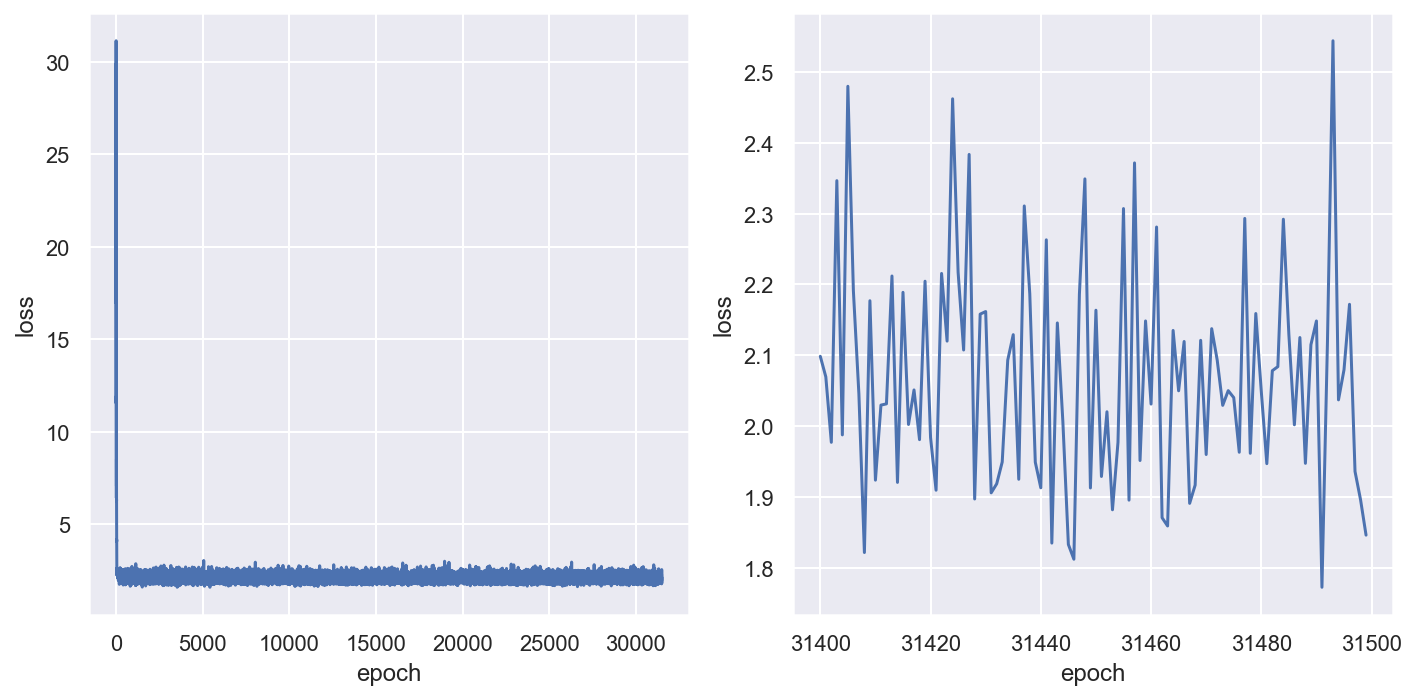

In [33]:
plot_loss(hist_loss, zoom_start=100)

In [34]:
def show_samples(s0, sk, mu, truth):
    
    alpha = 0.2
    
    mask_1 = (z0.data[:, 0] > mu[0]) & (z0.data[:, 1] > mu[1])
    mask_2 = (z0.data[:, 0] > mu[0]) & (z0.data[:, 1] < mu[1])
    mask_3 = (z0.data[:, 0] < mu[0]) & (z0.data[:, 1] > mu[1])
    mask_4 = (z0.data[:, 0] < mu[0]) & (z0.data[:, 1] < mu[1])
    
    for s, title in zip([s0, sk], ['Base distribution $z_0$', '$z_k$']):
        plt.figure(figsize=(8, 8))
        plt.title(title)
        plt.scatter(s[:, 0][mask_1], s[:, 1][mask_1], color='C0', alpha=alpha)
        plt.scatter(s[:, 0][mask_2], s[:, 1][mask_2], color='C1', alpha=alpha)
        plt.scatter(s[:, 0][mask_3], s[:, 1][mask_3], color='C3', alpha=alpha)
        plt.scatter(s[:, 0][mask_4], s[:, 1][mask_4], color='C4', alpha=alpha)
        
        plt.xlim(-7.5, 7.5)
        plt.ylim(-7.5, 7.5)
        
        # Plot truth
        plt.scatter(truth['mu'], np.log(truth['std']**2), color='black', alpha=1)
        
        plt.show()

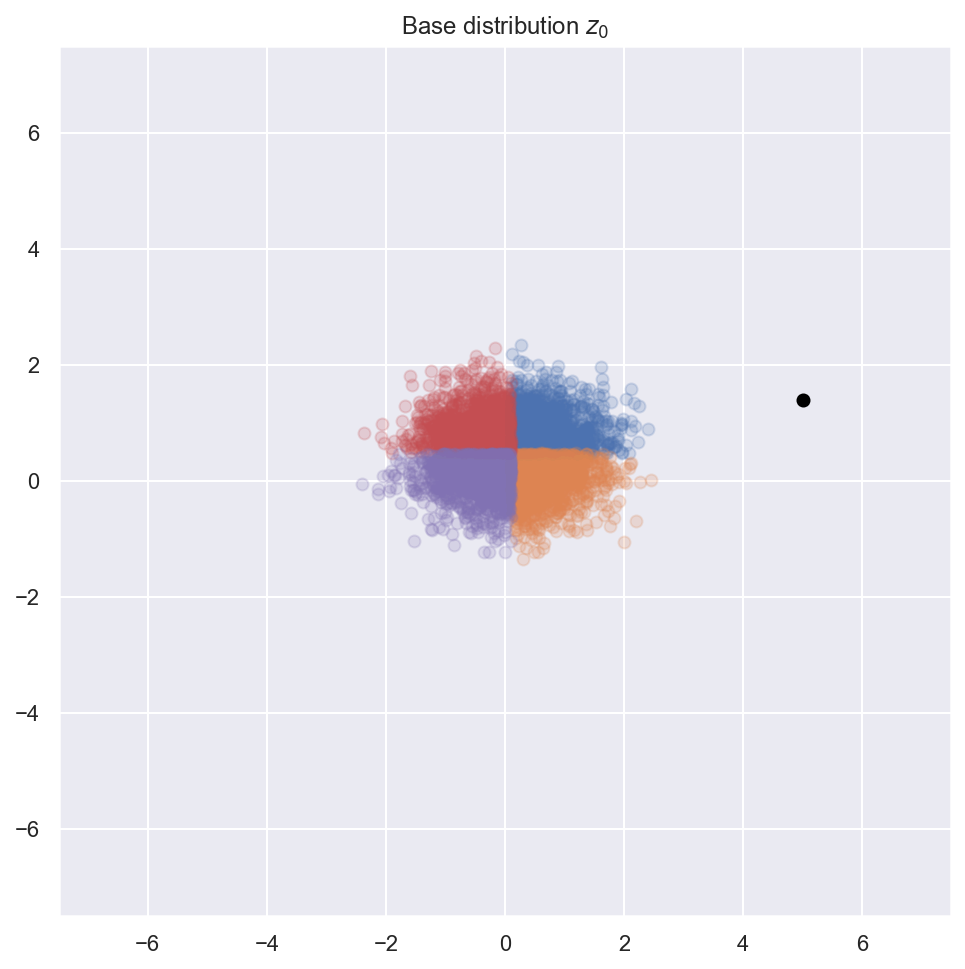

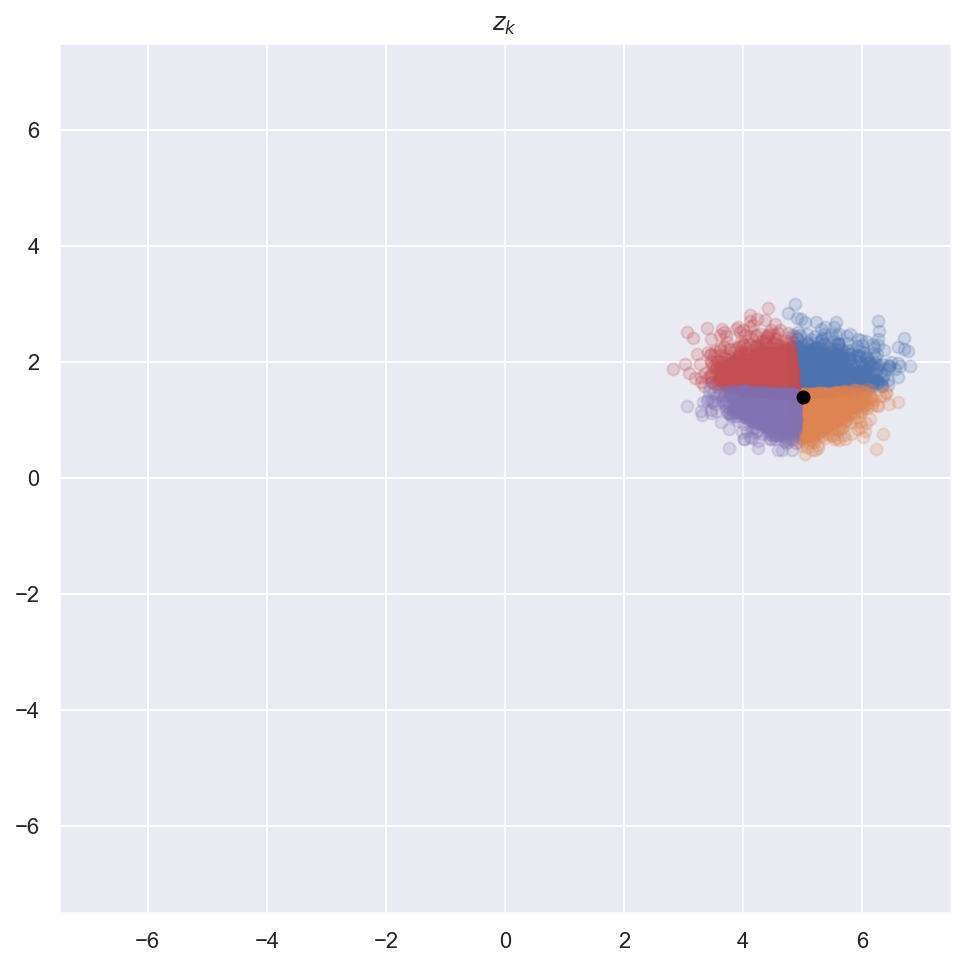

In [35]:
z0, zk, ldj, mu, log_var = flow(5000)
show_samples(z0.data, zk.data, mu, truth={'mu': mu_x, 'std': std_x})

In [36]:
zk_mu = np.array(zk.data[:, 0])
zk_std = np.array(zk.data[:, 1])

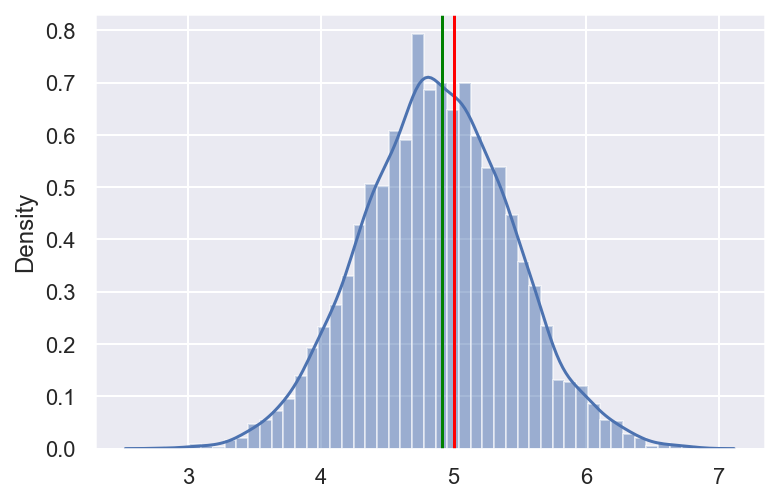

In [37]:
fig, ax = plt.subplots()
ax.hist(zk_mu, bins='auto', alpha=0.5, density=True)
sns.kdeplot(zk_mu, ax=ax, color='C0')
ax.axvline(x=mu_x, color='red')
ax.axvline(x=x.mean(), color='green');

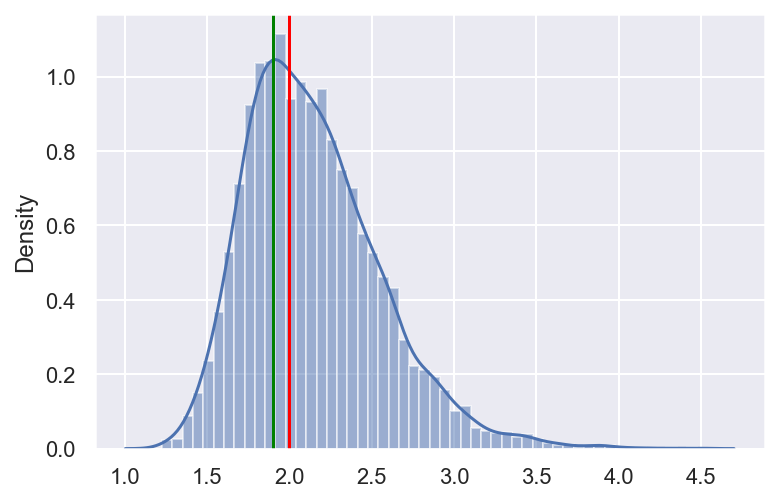

In [38]:
fig, ax = plt.subplots()
ax.hist(np.exp(0.5*zk_std), bins='auto', alpha=0.5, density=True)
sns.kdeplot(np.exp(0.5*zk_std), ax=ax, color='C0')
ax.axvline(x=std_x, color='red');
ax.axvline(x=x.std(), color='green');